# LRA

This notebook implements low-rank approximation for image reconstruction.

It is designed taking inspiration from [this post](https://medium.com/@rameshputalapattu/jupyter-python-image-compression-and-svd-an-interactive-exploration-703c953e44f6), properly modified and enriched by elements that complete the overview of SVD applied to LRA.

The images taken into consideration are not only grayscale images, but also RGB images processed using the layers method described below.

## Import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.color import rgb2gray, rgba2rgb
import scipy.misc

## Data

In [ ]:
# The following dictionaries contain the images on which we can perform LRA
# They included all the images from skimage.data considered significant for the task (some images don't let us to appreciate the reconstruction, and they are excluded)
gray_images = {
    "ascent": scipy.misc.ascent(),
    "brain": data.brain()[0],
    "brick": data.brick(),
    "camera": data.camera(),
    "checkerboard": data.checkerboard(),
    "coins": data.coins(),
    "horse": data.horse(),
    "page": data.page(),
    "text": data.text()
}

color_images = {
    "astronaut": data.astronaut(),
    "cat": data.cat(),
    "coffee": data.coffee(),
    "rocket": data.rocket(),
    "motorcycle": data.stereo_motorcycle()[0]
}

# The set of gray_images include the ones that are natively grayscale image plus RGB images converted in grayscale
for k, v in color_images.items():
  gray_images.setdefault(k, rgb2gray(v))

In [ ]:
# Choose the image using user's keyboard input
# If the chosen image is an RGB image, choose whether transform it to grayscale or not
print("Enter the name of the image ('h' for help): ")
image_name = input()

while image_name not in gray_images.keys():
  if image_name == "h":
    print("Choose the name among the following ones: ")
    print(list(gray_images.keys()))
  else:
    print("Error")
  
  print("Enter the name of the image ('h' for help): ")
  image_name = input()

gray = None

if image_name in color_images.keys():
  while gray == None:
    print("Enter 'g' if you want a grayscale image, 'c' otherwise: ")
    color_string = input()
    if color_string == 'g':
      gray = True
    elif color_string == 'c':
      gray = False
else:
  gray = True

Enter the name of the image ('h' for help): 
cat
Enter 'g' if you want a grayscale image, 'c' otherwise: 
g


## LRA

Image shape: (300, 451)
Number of entries: 135300
Rank: 300


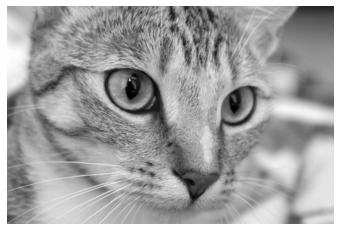

In [ ]:
# From here, the processing depends on the fact that we have a grayscale image or an RGB image
# In this first step, we retrieve the image and we compute some features of the corresponding matrix (shape, number of entries and rank)
if gray:
  image = gray_images[image_name]
  print("Image shape: {}".format(image.shape))

  image_entries = image.shape[0] * image.shape[1]
  print("Number of entries: {}".format(image_entries))
  print("Rank: {}".format(np.linalg.matrix_rank(image)))
else:
  image = color_images[image_name]
  print("Image shape: {}".format(image.shape))

  image_entries = image.shape[0] * image.shape[1] * image.shape[2]
  print("Number of entries: {}".format(image_entries))
  print("Rank per channel: {}".format(np.linalg.matrix_rank(image[:,:,0])))

# Print the original image
plt.imshow(image, cmap="gray")
plt.axis('off')
plt.show()

Number of singular values: 300


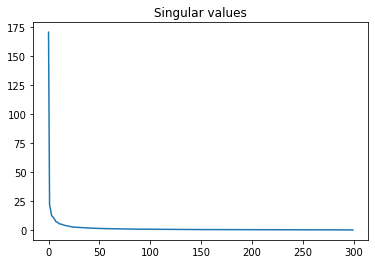

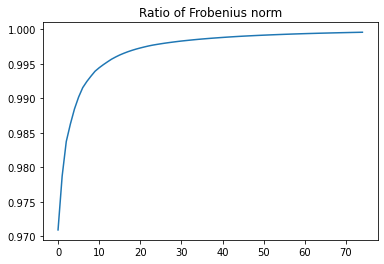

In [ ]:
# here is the singular value decomposition of the matrix and the computation of Frobenius norm
# it is possible to plot the singular values and the ratio of Frobenius norm retained in LRA truncated wrt each singular value
if gray:
  svd_chann = [np.linalg.svd(image, full_matrices=False)]
  _, s, _ = svd_chann[0]
  image_frobenius = round(np.sqrt(np.sum(np.square(s))), 4) # np.linalg.norm(image)

  print("Number of singular values: {}".format(len(s)))

  plt.title("Singular values")
  plt.plot(s)
  plt.show()

  plt.title("Ratio of Frobenius norm")
  plt.plot((np.sqrt(np.cumsum(np.square(s))) / np.sqrt(np.sum(np.square(s))))[:75])
  plt.show()
else:
  # in the case of RGB images, it is possible to perform SVD and LRA for each channel as a stand-alone matrix, and then unite the channels once compressed (layers method)
  # in this case, some features (rank, Frobenius norm, ...) are computed wrt only the first channel (on the contrary, the compression ratio is computed wrt the whole image)
  svd_chann = [np.linalg.svd(image[:,:,i], full_matrices=False) for i in range(3)]
  _, s, _ = svd_chann[0]
  image_frobenius_c0 = round(np.sqrt(np.sum(np.square(s))), 4)
  
  print("Number of singular values per channel: {}".format(len(s)))
  
  plt.title("Singular values (channel 1)")
  plt.plot(s)
  plt.show()

  plt.title("Ratio of Frobenius norm (channel 1)")
  plt.plot((np.sqrt(np.cumsum(np.square(s))) / np.sqrt(np.sum(np.square(s))))[:75])
  plt.show()

Percentage of SVs: 5%
Rank: 15
Number of entries: 11280
Compression ratio: 0.0834
Frobenius norm of lra: 174.8233
Frobenius norm of image-lra: 15.7373
Percentage of Frobenius norm: 99.5973%


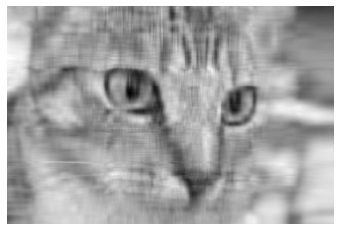

-------------------------------------------------
Percentage of SVs: 10%
Rank: 30
Number of entries: 22560
Compression ratio: 0.1667
Frobenius norm of lra: 175.2167
Frobenius norm of image-lra: 10.4861
Percentage of Frobenius norm: 99.8215%


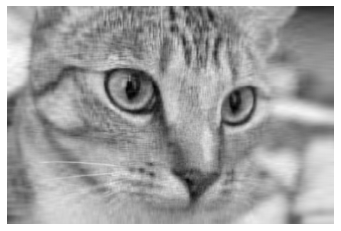

-------------------------------------------------
Percentage of SVs: 25%
Rank: 75
Number of entries: 56400
Compression ratio: 0.4169
Frobenius norm of lra: 175.4524
Frobenius norm of image-lra: 5.2238
Percentage of Frobenius norm: 99.9557%


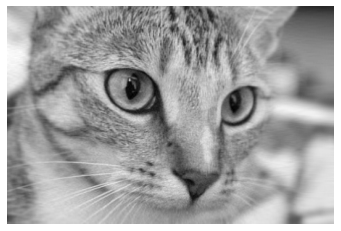

-------------------------------------------------
Percentage of SVs: 50%
Rank: 150
Number of entries: 112800
Compression ratio: 0.8337
Frobenius norm of lra: 175.5185
Frobenius norm of image-lra: 2.0208
Percentage of Frobenius norm: 99.9934%


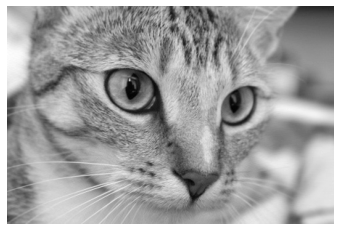

-------------------------------------------------


In [ ]:
# finally, here is the actual LRA computed wrt 5%, 10%, 25% and 50% of the total number of singular values
# for each case, we compute the number of entries needed and the compression ratio (that tells us how good is the approximation in terms of space required)
# for each case, we compute also the Frobenius norm of LRA (and image minus LRA) and the percentage of Frobenius norm retained in that particular situation
percent = np.array([0.05, 0.1, 0.25, 0.5])

for idx, k in enumerate((len(s) * percent).astype(int)):
  if gray:
    u, s, v = svd_chann[0]
    lra = u[:,:k] @ np.diag(s[:k]) @ v[:k,:]

    print("Percentage of SVs: {}%".format(int(percent[idx] * 100)))
    print("Rank: {}".format(np.linalg.matrix_rank(lra)))

    lra_entries = image.shape[0] * k + k + k * image.shape[1]
    compression_ratio = round(lra_entries / image_entries, 4)
    print("Number of entries: {}".format(lra_entries))
    print("Compression ratio: {}".format(compression_ratio))

    lra_frobenius = round(np.sqrt(np.sum(np.square(s[:k]))), 4)
    img_lra_frobenius = round(np.linalg.norm(image - lra), 4)
    print("Frobenius norm of lra: {}".format(lra_frobenius))
    print("Frobenius norm of image-lra: {}".format(img_lra_frobenius))
    print("Percentage of Frobenius norm: {}%".format(round(100 * lra_frobenius / image_frobenius, 4)))
    
    plt.imshow(lra, cmap='gray')
    plt.axis('off')
    plt.show()
    print("-------------------------------------------------")
  else:
    lra_chann = []

    # the LRA for RGB images is realized using the layers method described previously
    for i in range(3):
      u, s, v = svd_chann[i]
      lra_chann.append(u[:,:k] @ np.diag(s[:k]) @ v[:k,:])
    
    lra = np.dstack([lra_chann[i] for i in range(3)])

    print("Percentage of SVs per channel: {}%".format(int(percent[idx] * 100)))
    print("Rank per channel: {}".format(np.linalg.matrix_rank(lra[:,:,0])))

    lra_entries = (image.shape[0] * k + k + k * image.shape[1]) * image.shape[2]
    compression_ratio = round(lra_entries / image_entries, 4)
    print("Number of entries: {}".format(lra_entries))
    print("Compression ratio: {}".format(compression_ratio))

    lra_frobenius_c0 = round(np.sqrt(np.sum(np.square(svd_chann[0][1][:k]))), 4)
    img_lra_frobenius_c0 = round(np.sqrt(np.sum(np.square(svd_chann[0][1][k+1:]))), 4)
    print("Frobenius norm of lra (channel 1): {}".format(lra_frobenius_c0))
    print("Frobenius norm of image-lra (channel 1): {}".format(img_lra_frobenius_c0))
    print("Percentage of Frobenius norm (channel 1): {}%".format(round(100 * lra_frobenius_c0 / image_frobenius_c0, 4)))

    plt.imshow(lra.astype('uint8'), cmap='gray')
    plt.axis('off')
    plt.show()
    print("-------------------------------------------------")

## Considerations

The results show clearly how (and in what cases) SVD for LRA works effectively. From the first two plots we can clearly see how the most important singular values are the very first ones. The reference image for the tests is the "cat" image, but the following considerations involve all the images (unless otherwise specified).

Let's consider grayscale images first. In most cases, there is a huge difference if we truncate the approximation at 5%, 10% and 25% of the total number of singular values, both in terms of compression ratio (the lower the percentage, the fewer values you need) and of quality of the image (the higher the percentage, the better the quality). When we consider the gap between 25% and 50%, the quality of the images is not increasing so much, while the space needed to store the matrices is definitely more. This means that there is an obvious trade-off between these two parameters, and sometimes we can operate a less refined approximation if we are already satisfied by the reconstruction. 

One of the rare cases in which we may prefer a higher-rank approximation is when we want to avoid blurred portions in the image. An example is the "page" image, where we want to make understandable the words inside the picture.

The argument by which we should prefer the 25% approximation over the 50% approximation is furtherly strengthened by the fact that, in some cases, the number of entries needed to store the matrices in the 50% approximation is even greater than the number of entries of the original image (as happens in "ascent", "brain", "bricks", "camera", "checkerboard" and "astronaut").

Talking about the Frobenius norm, we can notice that the percentage of the Frobenius norm retained even in the 5% approximation is very high (more than 98%, sometimes even 99%). A particular case is met using the "checkerboard" image, in which we obtain a perfect reconstruction in all cases because of its significantly low rank (that suggests us the possibility of truncating the SVD even before 5%).

The very same considerations hold for RGB images. In this case, we can see also what portion of the image is more difficult to reconstruct when using LRA. In particular, it seems that we obtain poor quality in the portions of the images corresponding to the darker areas and along some edges of the pictured figures. This problem is mitigated by increasing the rank of the approximation, until it almost disappears in the 50% approximation.